# Rated DPG for Cartpole


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
import numpy as np
rewards = [each[3] for each in batch]
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.0


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [6]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [7]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [8]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [9]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                              labels=actions_labels)
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss = tf.reduce_mean(neg_log_prob * targetQs) # DPG: r+(gamma*nextQ)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True) # Qs
    rates = tf.reshape(rates, shape=[-1, 1])
    dlossA = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=rates)) # 0-1
    dlossA += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                     labels=rates)) # 0-1
    dlossA /= 2
    dlossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ += tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    dlossQ /= 2
    return actions_logits, gQs, gloss, dlossA, dlossQ

In [10]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_lossA, d_lossQ, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_optA = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossA, var_list=d_vars)
        d_optQ = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossQ, var_list=d_vars)

    return g_opt, d_optA, d_optQ

In [11]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_lossA, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, 
            targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_optA, self.d_optQ = model_opt(g_loss=self.g_loss, 
                                                         d_lossA=self.d_lossA, 
                                                         d_lossQ=self.d_lossQ, 
                                                         g_learning_rate=g_learning_rate, 
                                                         d_learning_rate=d_learning_rate)

In [12]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [13]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [14]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e2)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [15]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [16]:
goal = 500
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done), -1])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/goal
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        num_step = 0 # reset

In [17]:
idx = np.random.choice(np.arange(memory_size// batch_size))
batch = np.array(memory.buffer)[idx*batch_size:(idx+1)*batch_size]
rates = np.array([each[5] for each in batch])
batch = batch[rates >= (np.max(rates)*0.9)]
states = np.array([each[0] for each in batch])
actions = np.array([each[1] for each in batch])
next_states = np.array([each[2] for each in batch])
rewards = np.array([each[3] for each in batch])
dones = np.array([each[4] for each in batch])
rates = np.array([each[5] for each in batch])

In [18]:
batch.shape, \
states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape

((52, 6), (52, 4), (52,), (52, 4), (52,), (52,), (52,))

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [19]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list = [] # goal
rewards_list, gloss_list, dlossA_list, dlossQ_list = [], [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111):
        gloss_batch, dlossA_batch, dlossQ_batch= [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode
        total_reward = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
                #print(action)
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits) # adding epsilon*noise
                #print(action)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), -1])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the last played episode
            if done is True:
                rate = total_reward/ goal # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][5] == -1: # double-check if it is empty and it is not rated!
                        memory.buffer[-1-idx][5] = rate # rate each SA pair
            
            # Training using a max rated batch
            while True:
                idx = np.random.choice(np.arange(memory_size// batch_size))
                batch = np.array(memory.buffer)[idx*batch_size:(idx+1)*batch_size]
                rates = np.array([each[5] for each in batch])
                if (np.max(rates)*0.9) > 0: # non-rated data -1
                    break
            batch = batch[rates >= (np.max(rates)*0.9)]
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            rates = np.array([each[5] for each in batch])            
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            gloss, dlossA, dlossQ, _, _, _ = sess.run([model.g_loss, model.d_lossA, model.d_lossQ, 
                                                       model.g_opt, model.d_optA, model.d_optQ],
                                                      feed_dict = {model.states: states, 
                                                                   model.actions: actions,
                                                                   model.targetQs: targetQs, 
                                                                   model.rates: rates})
            gloss_batch.append(gloss)
            dlossA_batch.append(dlossA)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dlossA:{:.4f}'.format(np.mean(dlossA_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        dlossA_list.append([ep, np.mean(dlossA_batch)])
        dlossQ_list.append([ep, np.mean(dlossQ_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= goal:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:24.0000 R:24.0000 rate:0.0480 gloss:0.6395 dlossA:0.6360 dlossQ:1.1719 exploreP:0.9976
Episode:1 meanR:22.0000 R:20.0000 rate:0.0400 gloss:0.6593 dlossA:0.6513 dlossQ:1.1578 exploreP:0.9957
Episode:2 meanR:19.0000 R:13.0000 rate:0.0260 gloss:0.6552 dlossA:0.6468 dlossQ:1.1518 exploreP:0.9944
Episode:3 meanR:19.2500 R:20.0000 rate:0.0400 gloss:0.6462 dlossA:0.6395 dlossQ:1.1624 exploreP:0.9924
Episode:4 meanR:17.6000 R:11.0000 rate:0.0220 gloss:0.6463 dlossA:0.6414 dlossQ:1.1641 exploreP:0.9913
Episode:5 meanR:17.5000 R:17.0000 rate:0.0340 gloss:0.6303 dlossA:0.6337 dlossQ:1.1602 exploreP:0.9897
Episode:6 meanR:17.2857 R:16.0000 rate:0.0320 gloss:0.6548 dlossA:0.6474 dlossQ:1.1483 exploreP:0.9881
Episode:7 meanR:17.3750 R:18.0000 rate:0.0360 gloss:0.6496 dlossA:0.6419 dlossQ:1.1662 exploreP:0.9863
Episode:8 meanR:16.5556 R:10.0000 rate:0.0200 gloss:0.6282 dlossA:0.6323 dlossQ:1.1895 exploreP:0.9854
Episode:9 meanR:16.1000 R:12.0000 rate:0.0240 gloss:0.6519 dlossA:0.6534 

Episode:79 meanR:23.9125 R:82.0000 rate:0.1640 gloss:0.6261 dlossA:0.6324 dlossQ:1.1655 exploreP:0.8276
Episode:80 meanR:23.7901 R:14.0000 rate:0.0280 gloss:0.6311 dlossA:0.6365 dlossQ:1.1577 exploreP:0.8265
Episode:81 meanR:23.7439 R:20.0000 rate:0.0400 gloss:0.6096 dlossA:0.6272 dlossQ:1.1803 exploreP:0.8249
Episode:82 meanR:23.5904 R:11.0000 rate:0.0220 gloss:0.6335 dlossA:0.6384 dlossQ:1.1536 exploreP:0.8240
Episode:83 meanR:23.4167 R:9.0000 rate:0.0180 gloss:0.6382 dlossA:0.6486 dlossQ:1.1327 exploreP:0.8232
Episode:84 meanR:23.5059 R:31.0000 rate:0.0620 gloss:0.6121 dlossA:0.6238 dlossQ:1.1835 exploreP:0.8207
Episode:85 meanR:23.5930 R:31.0000 rate:0.0620 gloss:0.6226 dlossA:0.6339 dlossQ:1.1624 exploreP:0.8182
Episode:86 meanR:23.4943 R:15.0000 rate:0.0300 gloss:0.6264 dlossA:0.6380 dlossQ:1.1688 exploreP:0.8170
Episode:87 meanR:23.5341 R:27.0000 rate:0.0540 gloss:0.6314 dlossA:0.6359 dlossQ:1.1560 exploreP:0.8148
Episode:88 meanR:23.6517 R:34.0000 rate:0.0680 gloss:0.6217 dloss

Episode:158 meanR:34.3800 R:18.0000 rate:0.0360 gloss:0.5640 dlossA:0.6131 dlossQ:1.1126 exploreP:0.6290
Episode:159 meanR:34.8200 R:59.0000 rate:0.1180 gloss:0.5812 dlossA:0.6194 dlossQ:1.1165 exploreP:0.6254
Episode:160 meanR:34.8500 R:21.0000 rate:0.0420 gloss:0.5743 dlossA:0.6157 dlossQ:1.1281 exploreP:0.6241
Episode:161 meanR:35.1900 R:61.0000 rate:0.1220 gloss:0.5800 dlossA:0.6163 dlossQ:1.1313 exploreP:0.6203
Episode:162 meanR:35.6200 R:92.0000 rate:0.1840 gloss:0.5813 dlossA:0.6170 dlossQ:1.1416 exploreP:0.6147
Episode:163 meanR:35.5200 R:44.0000 rate:0.0880 gloss:0.5818 dlossA:0.6161 dlossQ:1.1327 exploreP:0.6121
Episode:164 meanR:35.9400 R:59.0000 rate:0.1180 gloss:0.5785 dlossA:0.6148 dlossQ:1.1424 exploreP:0.6085
Episode:165 meanR:35.9300 R:46.0000 rate:0.0920 gloss:0.5847 dlossA:0.6224 dlossQ:1.1175 exploreP:0.6058
Episode:166 meanR:35.7200 R:12.0000 rate:0.0240 gloss:0.5716 dlossA:0.6052 dlossQ:1.2019 exploreP:0.6051
Episode:167 meanR:35.6800 R:28.0000 rate:0.0560 gloss:0

Episode:236 meanR:48.7300 R:56.0000 rate:0.1120 gloss:0.5615 dlossA:0.6073 dlossQ:1.1361 exploreP:0.4269
Episode:237 meanR:49.1800 R:82.0000 rate:0.1640 gloss:0.5635 dlossA:0.6115 dlossQ:1.1374 exploreP:0.4235
Episode:238 meanR:49.8900 R:86.0000 rate:0.1720 gloss:0.5680 dlossA:0.6093 dlossQ:1.1385 exploreP:0.4199
Episode:239 meanR:49.8900 R:20.0000 rate:0.0400 gloss:0.5621 dlossA:0.6170 dlossQ:1.1208 exploreP:0.4191
Episode:240 meanR:50.3900 R:92.0000 rate:0.1840 gloss:0.5606 dlossA:0.6111 dlossQ:1.1151 exploreP:0.4154
Episode:241 meanR:49.7000 R:17.0000 rate:0.0340 gloss:0.5547 dlossA:0.6064 dlossQ:1.1376 exploreP:0.4147
Episode:242 meanR:49.3000 R:27.0000 rate:0.0540 gloss:0.5595 dlossA:0.6032 dlossQ:1.1879 exploreP:0.4136
Episode:243 meanR:49.7200 R:81.0000 rate:0.1620 gloss:0.5469 dlossA:0.6055 dlossQ:1.1174 exploreP:0.4103
Episode:244 meanR:49.8200 R:102.0000 rate:0.2040 gloss:0.5668 dlossA:0.6126 dlossQ:1.1340 exploreP:0.4063
Episode:245 meanR:50.1100 R:85.0000 rate:0.1700 gloss:

Episode:314 meanR:77.0300 R:115.0000 rate:0.2300 gloss:0.5315 dlossA:0.6002 dlossQ:1.1434 exploreP:0.2314
Episode:315 meanR:77.0100 R:57.0000 rate:0.1140 gloss:0.5238 dlossA:0.6038 dlossQ:1.1342 exploreP:0.2302
Episode:316 meanR:77.7200 R:100.0000 rate:0.2000 gloss:0.5128 dlossA:0.5925 dlossQ:1.1314 exploreP:0.2280
Episode:317 meanR:77.3800 R:106.0000 rate:0.2120 gloss:0.5121 dlossA:0.5968 dlossQ:1.1219 exploreP:0.2257
Episode:318 meanR:78.3800 R:156.0000 rate:0.3120 gloss:0.5153 dlossA:0.5982 dlossQ:1.1145 exploreP:0.2223
Episode:319 meanR:79.6100 R:191.0000 rate:0.3820 gloss:0.5035 dlossA:0.5931 dlossQ:1.1194 exploreP:0.2183
Episode:320 meanR:80.8200 R:152.0000 rate:0.3040 gloss:0.5144 dlossA:0.5962 dlossQ:1.1268 exploreP:0.2152
Episode:321 meanR:81.2700 R:75.0000 rate:0.1500 gloss:0.5099 dlossA:0.5925 dlossQ:1.1489 exploreP:0.2137
Episode:322 meanR:81.5500 R:100.0000 rate:0.2000 gloss:0.4985 dlossA:0.5950 dlossQ:1.1173 exploreP:0.2116
Episode:323 meanR:81.8800 R:90.0000 rate:0.1800 

Episode:392 meanR:110.9900 R:93.0000 rate:0.1860 gloss:0.3893 dlossA:0.5787 dlossQ:1.1082 exploreP:0.0989
Episode:393 meanR:111.3800 R:107.0000 rate:0.2140 gloss:0.3905 dlossA:0.5816 dlossQ:1.1786 exploreP:0.0979
Episode:394 meanR:111.4200 R:81.0000 rate:0.1620 gloss:0.3948 dlossA:0.5758 dlossQ:1.1470 exploreP:0.0972
Episode:395 meanR:111.3900 R:87.0000 rate:0.1740 gloss:0.3866 dlossA:0.5853 dlossQ:1.1703 exploreP:0.0965
Episode:396 meanR:111.3300 R:78.0000 rate:0.1560 gloss:0.3920 dlossA:0.5754 dlossQ:1.1133 exploreP:0.0958
Episode:397 meanR:110.7800 R:69.0000 rate:0.1380 gloss:0.3850 dlossA:0.5760 dlossQ:1.1608 exploreP:0.0952
Episode:398 meanR:111.0500 R:93.0000 rate:0.1860 gloss:0.4062 dlossA:0.5832 dlossQ:1.1436 exploreP:0.0944
Episode:399 meanR:110.6900 R:73.0000 rate:0.1460 gloss:0.3813 dlossA:0.5701 dlossQ:1.1124 exploreP:0.0938
Episode:400 meanR:110.9200 R:105.0000 rate:0.2100 gloss:0.3560 dlossA:0.5619 dlossQ:1.1475 exploreP:0.0929
Episode:401 meanR:110.8700 R:66.0000 rate:0.

Episode:470 meanR:89.9400 R:71.0000 rate:0.1420 gloss:-0.3653 dlossA:0.4998 dlossQ:1.4868 exploreP:0.0544
Episode:471 meanR:90.0600 R:90.0000 rate:0.1800 gloss:-0.3676 dlossA:0.5084 dlossQ:1.5457 exploreP:0.0540
Episode:472 meanR:89.5500 R:47.0000 rate:0.0940 gloss:-0.3752 dlossA:0.5061 dlossQ:1.6849 exploreP:0.0538
Episode:473 meanR:89.3700 R:83.0000 rate:0.1660 gloss:-0.4147 dlossA:0.5065 dlossQ:1.5304 exploreP:0.0535
Episode:474 meanR:89.0800 R:49.0000 rate:0.0980 gloss:-0.5637 dlossA:0.5201 dlossQ:1.8979 exploreP:0.0533
Episode:475 meanR:88.7600 R:57.0000 rate:0.1140 gloss:-0.5024 dlossA:0.4912 dlossQ:1.9277 exploreP:0.0530
Episode:476 meanR:88.5900 R:59.0000 rate:0.1180 gloss:-0.3758 dlossA:0.5059 dlossQ:1.5980 exploreP:0.0528
Episode:477 meanR:88.2800 R:47.0000 rate:0.0940 gloss:-0.7484 dlossA:0.5044 dlossQ:2.3387 exploreP:0.0526
Episode:478 meanR:88.7200 R:191.0000 rate:0.3820 gloss:-0.8444 dlossA:0.4961 dlossQ:2.0620 exploreP:0.0518
Episode:479 meanR:87.1300 R:62.0000 rate:0.12

Episode:548 meanR:54.2600 R:44.0000 rate:0.0880 gloss:-0.5842 dlossA:0.5029 dlossQ:1.3506 exploreP:0.0406
Episode:549 meanR:53.9400 R:40.0000 rate:0.0800 gloss:-1.6221 dlossA:0.4811 dlossQ:1.5493 exploreP:0.0405
Episode:550 meanR:53.1900 R:35.0000 rate:0.0700 gloss:-0.5034 dlossA:0.5183 dlossQ:1.3828 exploreP:0.0404
Episode:551 meanR:52.8900 R:34.0000 rate:0.0680 gloss:-1.1049 dlossA:0.4863 dlossQ:1.4005 exploreP:0.0403
Episode:552 meanR:52.6000 R:41.0000 rate:0.0820 gloss:-1.2084 dlossA:0.4783 dlossQ:1.6406 exploreP:0.0401
Episode:553 meanR:51.0200 R:30.0000 rate:0.0600 gloss:-0.9082 dlossA:0.4886 dlossQ:1.3080 exploreP:0.0400
Episode:554 meanR:50.5700 R:29.0000 rate:0.0580 gloss:-1.8280 dlossA:0.4601 dlossQ:1.4691 exploreP:0.0400
Episode:555 meanR:49.9000 R:31.0000 rate:0.0620 gloss:-1.3601 dlossA:0.4721 dlossQ:1.3928 exploreP:0.0399
Episode:556 meanR:49.5500 R:31.0000 rate:0.0620 gloss:-0.9489 dlossA:0.5395 dlossQ:1.3129 exploreP:0.0398
Episode:557 meanR:49.5600 R:47.0000 rate:0.094

Episode:626 meanR:47.3400 R:52.0000 rate:0.1040 gloss:-2.4389 dlossA:0.4884 dlossQ:1.5734 exploreP:0.0308
Episode:627 meanR:47.9100 R:89.0000 rate:0.1780 gloss:-2.5007 dlossA:0.4877 dlossQ:1.4466 exploreP:0.0306
Episode:628 meanR:48.5600 R:108.0000 rate:0.2160 gloss:-2.1716 dlossA:0.4925 dlossQ:1.4679 exploreP:0.0304
Episode:629 meanR:48.6900 R:45.0000 rate:0.0900 gloss:-2.5325 dlossA:0.4772 dlossQ:1.4894 exploreP:0.0303
Episode:630 meanR:48.7000 R:47.0000 rate:0.0940 gloss:-2.1399 dlossA:0.4849 dlossQ:1.3838 exploreP:0.0302
Episode:631 meanR:48.9000 R:49.0000 rate:0.0980 gloss:-2.5627 dlossA:0.4896 dlossQ:1.6015 exploreP:0.0301
Episode:632 meanR:51.0100 R:249.0000 rate:0.4980 gloss:-2.4027 dlossA:0.4920 dlossQ:1.4933 exploreP:0.0296
Episode:633 meanR:51.2900 R:54.0000 rate:0.1080 gloss:-1.0893 dlossA:0.4788 dlossQ:1.3424 exploreP:0.0295
Episode:634 meanR:51.5000 R:68.0000 rate:0.1360 gloss:-2.0829 dlossA:0.5016 dlossQ:1.3611 exploreP:0.0294
Episode:635 meanR:51.4500 R:42.0000 rate:0.0

Episode:704 meanR:65.3000 R:53.0000 rate:0.1060 gloss:-3.1016 dlossA:0.5028 dlossQ:1.3048 exploreP:0.0225
Episode:705 meanR:65.3000 R:39.0000 rate:0.0780 gloss:-2.4793 dlossA:0.5054 dlossQ:1.4247 exploreP:0.0224
Episode:706 meanR:64.9400 R:56.0000 rate:0.1120 gloss:-6.2564 dlossA:0.4844 dlossQ:1.4120 exploreP:0.0224
Episode:707 meanR:64.9400 R:48.0000 rate:0.0960 gloss:-3.7782 dlossA:0.4837 dlossQ:1.3729 exploreP:0.0223
Episode:708 meanR:64.8000 R:40.0000 rate:0.0800 gloss:-6.4364 dlossA:0.5057 dlossQ:1.4865 exploreP:0.0223
Episode:709 meanR:64.6600 R:44.0000 rate:0.0880 gloss:-4.2093 dlossA:0.5019 dlossQ:1.4463 exploreP:0.0222
Episode:710 meanR:64.7700 R:47.0000 rate:0.0940 gloss:-4.6101 dlossA:0.4777 dlossQ:1.3271 exploreP:0.0221
Episode:711 meanR:64.8900 R:49.0000 rate:0.0980 gloss:-2.9160 dlossA:0.4794 dlossQ:1.2728 exploreP:0.0221
Episode:712 meanR:65.7600 R:123.0000 rate:0.2460 gloss:-1.9529 dlossA:0.4912 dlossQ:1.4042 exploreP:0.0219
Episode:713 meanR:65.8000 R:50.0000 rate:0.10

Episode:782 meanR:65.2500 R:49.0000 rate:0.0980 gloss:-2.4004 dlossA:0.5093 dlossQ:1.1164 exploreP:0.0175
Episode:783 meanR:65.4600 R:60.0000 rate:0.1200 gloss:-7.1857 dlossA:0.4877 dlossQ:1.3002 exploreP:0.0174
Episode:784 meanR:65.7200 R:68.0000 rate:0.1360 gloss:-4.2540 dlossA:0.4961 dlossQ:1.2053 exploreP:0.0174
Episode:785 meanR:65.7900 R:50.0000 rate:0.1000 gloss:-3.2449 dlossA:0.4770 dlossQ:1.4703 exploreP:0.0173
Episode:786 meanR:65.8400 R:40.0000 rate:0.0800 gloss:-2.7206 dlossA:0.5061 dlossQ:1.1197 exploreP:0.0173
Episode:787 meanR:66.1700 R:75.0000 rate:0.1500 gloss:-4.6500 dlossA:0.4920 dlossQ:1.3603 exploreP:0.0172
Episode:788 meanR:66.1700 R:50.0000 rate:0.1000 gloss:-3.5219 dlossA:0.5006 dlossQ:1.1984 exploreP:0.0172
Episode:789 meanR:65.8300 R:64.0000 rate:0.1280 gloss:-5.7749 dlossA:0.4936 dlossQ:1.3786 exploreP:0.0172
Episode:790 meanR:66.0400 R:59.0000 rate:0.1180 gloss:-4.8901 dlossA:0.4771 dlossQ:1.3915 exploreP:0.0171
Episode:791 meanR:67.2300 R:168.0000 rate:0.33

Episode:860 meanR:68.9700 R:83.0000 rate:0.1660 gloss:-7.2233 dlossA:0.5026 dlossQ:1.1599 exploreP:0.0145
Episode:861 meanR:69.0100 R:57.0000 rate:0.1140 gloss:-12.9766 dlossA:0.4877 dlossQ:1.3097 exploreP:0.0144
Episode:862 meanR:69.1800 R:77.0000 rate:0.1540 gloss:-13.6218 dlossA:0.4913 dlossQ:1.2729 exploreP:0.0144
Episode:863 meanR:68.4300 R:48.0000 rate:0.0960 gloss:-20.4084 dlossA:0.4931 dlossQ:1.2853 exploreP:0.0144
Episode:864 meanR:68.1300 R:49.0000 rate:0.0980 gloss:-21.4016 dlossA:0.5239 dlossQ:1.6713 exploreP:0.0144
Episode:865 meanR:68.2700 R:52.0000 rate:0.1040 gloss:-9.2912 dlossA:0.4818 dlossQ:1.2792 exploreP:0.0143
Episode:866 meanR:68.3300 R:62.0000 rate:0.1240 gloss:-13.0402 dlossA:0.4935 dlossQ:1.2144 exploreP:0.0143
Episode:867 meanR:68.2400 R:41.0000 rate:0.0820 gloss:-26.5363 dlossA:0.4746 dlossQ:1.3761 exploreP:0.0143
Episode:868 meanR:68.2700 R:52.0000 rate:0.1040 gloss:-11.8275 dlossA:0.5041 dlossQ:1.2334 exploreP:0.0143
Episode:869 meanR:67.9400 R:42.0000 rat

Episode:937 meanR:53.8300 R:35.0000 rate:0.0700 gloss:-30.7108 dlossA:0.5313 dlossQ:1.6548 exploreP:0.0130
Episode:938 meanR:53.9500 R:57.0000 rate:0.1140 gloss:-48.1027 dlossA:0.5011 dlossQ:1.6818 exploreP:0.0130
Episode:939 meanR:53.8300 R:34.0000 rate:0.0680 gloss:-53.1174 dlossA:0.5131 dlossQ:1.9310 exploreP:0.0130
Episode:940 meanR:53.6400 R:31.0000 rate:0.0620 gloss:-48.2693 dlossA:0.5312 dlossQ:1.7471 exploreP:0.0130
Episode:941 meanR:53.7200 R:60.0000 rate:0.1200 gloss:-28.6457 dlossA:0.5221 dlossQ:1.6473 exploreP:0.0129
Episode:942 meanR:53.4800 R:33.0000 rate:0.0660 gloss:-43.5069 dlossA:0.5181 dlossQ:1.6758 exploreP:0.0129
Episode:943 meanR:53.1900 R:39.0000 rate:0.0780 gloss:-28.8866 dlossA:0.5285 dlossQ:1.8464 exploreP:0.0129
Episode:944 meanR:52.8400 R:31.0000 rate:0.0620 gloss:-32.4739 dlossA:0.5131 dlossQ:1.6976 exploreP:0.0129
Episode:945 meanR:52.1400 R:36.0000 rate:0.0720 gloss:-36.0954 dlossA:0.5042 dlossQ:1.6384 exploreP:0.0129
Episode:946 meanR:51.9400 R:58.0000 r

Episode:1014 meanR:36.5000 R:25.0000 rate:0.0500 gloss:-39.4406 dlossA:0.5353 dlossQ:2.3494 exploreP:0.0123
Episode:1015 meanR:36.1500 R:22.0000 rate:0.0440 gloss:-89.8576 dlossA:0.5329 dlossQ:1.8711 exploreP:0.0123
Episode:1016 meanR:36.1400 R:34.0000 rate:0.0680 gloss:-39.3528 dlossA:0.5676 dlossQ:2.5334 exploreP:0.0123
Episode:1017 meanR:35.9500 R:31.0000 rate:0.0620 gloss:-54.6477 dlossA:0.5119 dlossQ:1.8318 exploreP:0.0123
Episode:1018 meanR:35.7000 R:30.0000 rate:0.0600 gloss:-76.3051 dlossA:0.5136 dlossQ:1.8963 exploreP:0.0123
Episode:1019 meanR:35.5600 R:27.0000 rate:0.0540 gloss:-35.6708 dlossA:0.5348 dlossQ:1.7557 exploreP:0.0123
Episode:1020 meanR:35.0600 R:25.0000 rate:0.0500 gloss:-53.1498 dlossA:0.4977 dlossQ:1.8004 exploreP:0.0123
Episode:1021 meanR:34.8300 R:27.0000 rate:0.0540 gloss:-27.9280 dlossA:0.5459 dlossQ:1.8540 exploreP:0.0123
Episode:1022 meanR:34.7600 R:23.0000 rate:0.0460 gloss:-22.4937 dlossA:0.5413 dlossQ:1.9794 exploreP:0.0123
Episode:1023 meanR:34.6700 R

Episode:1090 meanR:27.1900 R:23.0000 rate:0.0460 gloss:-41.3148 dlossA:0.5225 dlossQ:1.6518 exploreP:0.0119
Episode:1091 meanR:27.1300 R:28.0000 rate:0.0560 gloss:-55.4298 dlossA:0.4978 dlossQ:1.9736 exploreP:0.0119
Episode:1092 meanR:27.1600 R:28.0000 rate:0.0560 gloss:-43.5700 dlossA:0.5193 dlossQ:1.9058 exploreP:0.0119
Episode:1093 meanR:27.0500 R:22.0000 rate:0.0440 gloss:-42.8155 dlossA:0.5033 dlossQ:1.7686 exploreP:0.0119
Episode:1094 meanR:27.0100 R:31.0000 rate:0.0620 gloss:-18.6389 dlossA:0.5393 dlossQ:1.7718 exploreP:0.0119
Episode:1095 meanR:27.0400 R:24.0000 rate:0.0480 gloss:-14.1756 dlossA:0.5466 dlossQ:1.8395 exploreP:0.0119
Episode:1096 meanR:27.1000 R:33.0000 rate:0.0660 gloss:-34.6658 dlossA:0.5173 dlossQ:2.0091 exploreP:0.0118
Episode:1097 meanR:27.0700 R:21.0000 rate:0.0420 gloss:-63.6492 dlossA:0.4951 dlossQ:1.8274 exploreP:0.0118
Episode:1098 meanR:27.0800 R:30.0000 rate:0.0600 gloss:-63.4284 dlossA:0.4832 dlossQ:1.7930 exploreP:0.0118
Episode:1099 meanR:27.0300 R

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

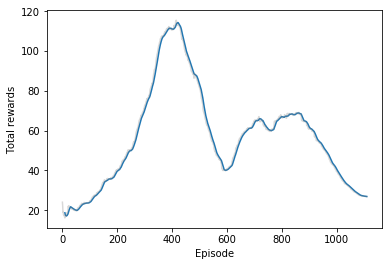

In [21]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

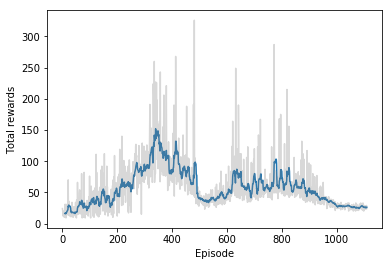

In [22]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [23]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

SyntaxError: invalid syntax (<ipython-input-23-a0b0af09d9f3>, line 6)

In [ ]:
eps, arr = np.array(dlossA_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

In [ ]:
eps, arr = np.array(dlossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.